# 漸變流直接積分法教學講義

介紹明渠水力學中漸變流水深計算的直接積分法，特別是基於 V. T. Chow 的經典教材所提出的方法。

## 1. 理論基礎

### 1.1 漸變流基本方程

在 V. T. Chow 的 Open-Channel Hydraulics 一書中，他提出了以下形式的漸變流基本微分方程式：

$$\frac{dy}{dx} = \frac{S_0 \left(1-\left(\frac{y_n}{y}\right)^N\right)}{1-\left(\frac{y_c}{y}\right)^M}$$

其中：
- $y$ 是水深
- $x$ 是沿程距離
- $S_0$ 是渠底坡度
- $y_n$ 是正規水深 (normal depth)
- $y_c$ 是臨界水深 (critical depth)
- $N$ 和 $M$ 是與斷面形狀有關的指數

### 1.2 指數 $N$ 和 $M$ 的含義

- **指數 $N$**：與能量坡度 $S_f$ 的計算有關。對於使用曼寧公式的情況，$N$ 通常為 3。
- **指數 $M$**：與臨界流條件有關。對於矩形斷面，$M$ 等於 3；對於三角形斷面，$M$ 等於 2；對於抛物線斷面，$M$ 等於 5/2。

### 1.3 水面曲線分類

漸變流的水面曲線可分為以下幾種：

1. **緩坡(M)曲線**：發生在坡度小於臨界坡度的情況
   - M1：水深大於正常水深和臨界水深 ($y > y_n > y_c$)
   - M2：水深介於正常水深和臨界水深之間 ($y_n > y > y_c$)
   - M3：水深小於臨界水深和正常水深 ($y_n > y_c > y$)

2. **陡坡(S)曲線**：發生在坡度大於臨界坡度的情況
   - S1：水深大於臨界水深和正常水深 ($y > y_c > y_n$)
   - S2：水深介於臨界水深和正常水深之間 ($y_c > y > y_n$)
   - S3：水深小於正常水深和臨界水深 ($y_c > y_n > y$)

3. **臨界坡(C)曲線**：發生在坡度等於臨界坡度的情況 ($y_c = y_n$)
   - C1：水深大於臨界水深（等於正常水深）($y > y_c = y_n$)
   - C3：水深小於臨界水深（等於正常水深）($y_c = y_n > y$)

## 2. 直接積分法

### 2.1 方法步驟

直接積分法的基本步驟如下：

1. **方程重排**：將方程改寫為 $dx$ 的形式
   
   $$dx = \frac{1-\left(\frac{y_c}{y}\right)^M}{S_0 \left(1-\left(\frac{y_n}{y}\right)^N\right)} dy$$

2. **積分求解**：
   
   $$x = \int_{y_1}^{y_2} \frac{1-\left(\frac{y_c}{y}\right)^M}{S_0 \left(1-\left(\frac{y_n}{y}\right)^N\right)} dy$$

3. **數值積分**：由於此積分通常無法得到解析解，需使用數值方法求解

## 3. 實作：導入必要的函式庫

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
from IPython.display import display, Markdown

# 設定中文字體顯示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'STHeiti', 'Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 4. 定義基本參數計算函數

In [2]:
# 定義正常水深計算函數
def calculate_normal_depth(Q, S0, n, b, m=0, max_iter=50, tol=1e-6):
    """
    使用Newton-Raphson法計算梯形渠道的正常水深
    
    參數:
    - Q: 流量 (m³/s)
    - S0: 底坡
    - n: 曼寧粗糙係數
    - b: 渠道底寬 (m)
    - m: 側邊斜率 (H:V = m:1), m = 0 時為矩形渠道
    - max_iter: 最大迭代次數
    - tol: 收斂容許誤差
    
    返回:
    - yn: 正常水深 (m)
    """
    # 重力加速度
    g = 9.81
    
    # 初始猜測值 (使用矩形渠道公式)
    y = (n * Q / (b * np.sqrt(S0))) ** (3/5)
    
    # 記錄迭代過程
    iterations = []
    
    # Newton-Raphson迭代
    for i in range(max_iter):
        # 計算截面參數
        A = b * y + m * y**2       # 截面積
        P = b + 2 * y * np.sqrt(1 + m**2)  # 濕周
        R = A / P                  # 水力半徑
        
        # 計算曼寧方程的函數值 (Q - K*sqrt(S0))
        K = (1/n) * A * R**(2/3)   # 渠道輸水能力係數
        f = Q - K * np.sqrt(S0)    
        
        # 記錄當前迭代
        iterations.append({
            'iteration': i+1,
            'y': y,
            'A': A,
            'P': P,
            'R': R,
            'K': K,
            'f': f
        })
        
        # 如果函數值足夠小，認為已收斂
        if abs(f) < tol:
            break
        
        # 計算導數 df/dy
        dA_dy = b + 2 * m * y      # A對y的導數
        dP_dy = 2 * np.sqrt(1 + m**2)  # P對y的導數
        dR_dy = (dA_dy * P - A * dP_dy) / P**2  # R對y的導數
        
        # K對y的導數
        dK_dy = (1/n) * (dA_dy * R**(2/3) + A * (2/3) * R**(-1/3) * dR_dy)
        
        # f對y的導數
        df_dy = -dK_dy * np.sqrt(S0)
        
        # Newton-Raphson迭代公式
        y_new = y - f / df_dy
        
        # 確保水深為正
        if y_new <= 0:
            y_new = y / 2  # 如果計算結果為負，使用當前值的一半
        
        # 檢查是否收斂
        if abs(y_new - y) < tol:
            y = y_new
            break
        
        y = y_new
    
    # 計算最終的正常水深
    yn = y
    
    # 計算截面特性用於驗證
    A_final = b * yn + m * yn**2
    P_final = b + 2 * yn * np.sqrt(1 + m**2)
    R_final = A_final / P_final
    V_final = Q / A_final
    Fr_final = V_final / np.sqrt(g * A_final / (b + 2 * m * yn))  # Froude number
    
    # 計算實際流量為驗證
    Q_calc = (1/n) * A_final * R_final**(2/3) * np.sqrt(S0)
    Q_error = (Q_calc - Q) / Q * 100  # 流量誤差(%)
    
    # 返回 yn
    return yn

    # 返回完整結果供驗證
    #return yn, {
    #    'Area': A_final, 
    #    'Perimeter': P_final, 
    #    'HydRadius': R_final, 
    #    'Velocity': V_final, 
    #    'Froude': Fr_final, 
    #    'Iterations': i+1, 
    #    'Q_calculated': Q_calc,
    #    'Q_error_percent': Q_error,
    #    'iteration_data': iterations}

# 定義臨界水深計算函數
def calculate_critical_depth(Q, b, m=0, max_iter=50, tol=1e-6):
    """
    使用Newton-Raphson法計算梯形渠道的臨界水深
    
    參數:
    - Q: 流量 (m³/s)
    - b: 渠道底寬 (m)
    - m: 側邊斜率 (H:V = m:1), m = 0 時為矩形渠道
    - max_iter: 最大迭代次數
    - tol: 收斂容許誤差
    
    返回:
    - yc: 臨界水深 (m)
    """
    
    # 重力加速度
    g = 9.81
    
    # 初始猜測值 (使用矩形渠道公式)
    if m == 0:
        # 矩形渠道臨界水深解析解
        y = (Q**2 / (g * b**2))**(1/3)
    else:
        # 梯形渠道的初始猜測（使用矩形公式作為近似）
        y = (Q**2 / (g * b**2))**(1/3)
    
    # Newton-Raphson迭代
    for i in range(max_iter):
        # 計算截面參數
        A = b * y + m * y**2       # 截面積
        B = b + 2 * m * y          # 水面寬度
        
        # 計算臨界水深方程的函數值 f(y) = Q^2*B - g*A^3 = 0
        # 臨界條件: Fr = 1 = V/sqrt(g*A/B) -> V^2 = g*A/B -> (Q/A)^2 = g*A/B -> Q^2*B = g*A^3
        f = Q**2 * B - g * A**3
        
        # 如果函數值足夠小，認為已收斂
        if abs(f) < tol:
            break
        
        # 計算導數 df/dy
        dA_dy = b + 2 * m * y      # A對y的導數
        dB_dy = 2 * m              # B對y的導數
        
        # f對y的導數: df/dy = Q^2*dB/dy - g*3*A^2*dA/dy
        df_dy = Q**2 * dB_dy - g * 3 * A**2 * dA_dy
        
        # Newton-Raphson迭代公式
        y_new = y - f / df_dy
        
        # 確保水深為正
        if y_new <= 0:
            y_new = y / 2  # 如果計算結果為負，使用當前值的一半
        
        # 檢查是否收斂
        if abs(y_new - y) < tol:
            y = y_new
            break
        
        y = y_new
    
    # 計算最終的臨界水深
    yc = y
    
    # 計算截面特性用於驗證
    A_final = b * yc + m * yc**2
    B_final = b + 2 * m * yc
    V_final = Q / A_final
    Fr_final = V_final / np.sqrt(g * A_final / B_final)  # 應該接近1.0
    
    # 可選：返回完整結果供驗證
    #return yc, {'Area': A_final, 'TopWidth': B_final, 'Velocity': V_final, 'Froude': Fr_final, 'Iterations': i+1}
    
    return yc

def get_exponents(channel_type='rectangular'):
    """
    根據渠道類型獲取指數 N 和 M
    
    參數:
    channel_type: 渠道類型 ('rectangular', 'triangular', 'parabolic')
    
    返回:
    N: 與能量坡度有關的指數
    M: 與臨界流條件有關的指數
    """
    if channel_type == 'rectangular':
        return 3, 3  # N=3, M=3
    elif channel_type == 'triangular':
        return 3, 2  # N=3, M=2
    elif channel_type == 'parabolic':
        return 3, 2.5  # N=3, M=5/2
    else:
        raise ValueError("未知的渠道類型")

## 5. 直接積分法核心函數

In [3]:
def integrand(y, y_n, y_c, S0, N, M):
    """
    計算被積函數
    
    參數:
    y: 水深
    y_n: 正常水深
    y_c: 臨界水深
    S0: 渠底坡度
    N: 與能量坡度有關的指數
    M: 與臨界流條件有關的指數
    
    返回:
    dx/dy 的值
    """
    numerator = 1 - (y_c/y)**M
    denominator = S0 * (1 - (y_n/y)**N)
    
    # 處理可能的除以零情況
    if abs(denominator) < 1e-10:
        return float('inf')
    
    return numerator / denominator

def direct_integration_method(y_n, y_c, S0, y_start, y_end, N, M, num_points=100):
    """
    使用直接積分法計算漸變流水面線
    
    參數:
    y_n: 正常水深
    y_c: 臨界水深
    S0: 渠底坡度
    y_start: 起始水深
    y_end: 終點水深
    N: 與能量坡度有關的指數
    M: 與臨界流條件有關的指數
    num_points: 計算點數
    
    返回:
    x: 距離數組
    y: 水深數組
    """
    # 確定積分方向
    if y_start > y_end:
        y_values = np.linspace(y_start, y_end, num_points)
        direction = -1
    else:
        y_values = np.linspace(y_start, y_end, num_points)
        direction = 1
    
    # 初始化距離數組
    x_values = [0]
    
    # 使用數值積分計算每個點的位置
    for i in range(1, len(y_values)):
        y_lower = y_values[i-1]
        y_upper = y_values[i]
        
        # 使用 scipy 的數值積分函數
        result, _ = integrate.quad(
            lambda y: integrand(y, y_n, y_c, S0, N, M),
            y_lower,
            y_upper
        )
        
        # 更新距離
        x_values.append(x_values[-1] + direction * result)
    
    return np.array(x_values), np.array(y_values)

def classify_profile(y_n, y_c, y):
    """
    根據水深、正常水深和臨界水深分類水面曲線
    
    參數:
    y_n: 正常水深
    y_c: 臨界水深
    y: 水深
    
    返回:
    profile_type: 水面曲線類型 (字符串)
    """
    if y_n > y_c:  # 緩坡 (M)
        if y > y_n:
            return "M1"
        elif y > y_c:
            return "M2"
        else:
            return "M3"
    elif y_c > y_n:  # 陡坡 (S)
        if y > y_c:
            return "S1"
        elif y > y_n:
            return "S2"
        else:
            return "S3"
    else:  # 臨界坡 (C)
        if y > y_c:
            return "C1"
        elif y < y_c:
            return "C3"
        else:
            return "臨界流"

## 6. 函數使用說明

在上面的程式碼中，我們定義了幾個關鍵函數：

1. **calculate_normal_depth**: 計算正常水深的函數，根據流量、曼寧粗糙係數、渠底坡度和渠道尺寸計算。

2. **calculate_critical_depth**: 計算臨界水深的函數，根據流量和渠道尺寸計算。

3. **get_exponents**: 獲取與渠道形狀相關的指數 N 和 M。

4. **integrand**: 計算積分方程中被積函數的值。

5. **direct_integration_method**: 實現直接積分法的核心函數，使用數值積分計算水面線。

6. **classify_profile**: 根據水深、正常水深和臨界水深的關係，分類水面曲線類型。

這些函數共同構成了漸變流直接積分法的計算框架。在實際應用中，我們將按照以下步驟使用這些函數：

1. 設定渠道參數（流量、曼寧粗糙係數、渠底坡度等）
2. 計算正常水深和臨界水深
3. 確定指數 N 和 M
4. 設定起始和終點水深
5. 應用直接積分法計算水面線
6. 分析和繪製結果

在接下來的部分中，我們將展示如何使用這些函數來計算實際案例。

## 7. 範例：矩形渠道的漸變流計算

In [ ]:
# 渠道參數設定
display(Markdown("### 渠道參數設定"))
channel_type = 'rectangular'
Q = 10.0  # 流量 (m³/s)
n = 0.015  # 曼寧粗糙係數
S0 = 0.001  # 渠底坡度
b = 5.0  # 渠道寬度 (m)
m = 0

print(f"渠道類型: {'矩形渠道'}")
print(f"流量 Q = {Q} m³/s")
print(f"曼寧粗糙係數 n = {n}")
print(f"渠底坡度 S₀ = {S0}")
print(f"渠道寬度 b = {b} m")

# 計算基本參數
display(Markdown("### 計算基本參數"))
y_n = calculate_normal_depth(Q, S0, n, b, m, max_iter=50, tol=1e-6)
y_c = calculate_critical_depth(Q, b, m=0, max_iter=50, tol=1e-6)
N, M = get_exponents(channel_type)

print(f"正常水深 y_n = {y_n:.2f} m")
print(f"臨界水深 y_c = {y_c:.2f} m")
print(f"指數 N = {N}, M = {M}")

# 設定起始和終點水深（從臨界水深的 1.01 倍到正常水深的 0.9 倍）
y_start = 1.01 * y_c  # 起始水深
y_end = 0.9 * y_n     # 終點水深

# 確定水面曲線類型
profile_type = classify_profile(y_n, y_c, y_start)

# 根據水面曲線類型顯示描述
profile_descriptions = {
    "M1": "(水深大於正常水深和臨界水深)",
    "M2": "(水深介於正常水深和臨界水深之間)",
    "M3": "(水深小於臨界水深和正常水深)",
    "S1": "(水深大於臨界水深和正常水深)",
    "S2": "(水深介於臨界水深和正常水深之間)",
    "S3": "(水深小於正常水深和臨界水深)",
    "C1": "(水深大於臨界水深（等於正常水深）)",
    "C3": "(水深小於臨界水深（等於正常水深）)"
}

description = profile_descriptions.get(profile_type, "")
print(f"水面曲線類型: {profile_type} {description}")

### 渠道參數設定

渠道類型: 矩形渠道
流量 Q = 10.0 m³/s
曼寧粗糙係數 n = 0.015
渠底坡度 S₀ = 0.001
渠道寬度 b = 5.0 m


### 計算基本參數

正常水深 y_n = 1.12 m
臨界水深 y_c = 0.74 m
指數 N = 3, M = 3
水面曲線類型: M2 (水深介於正常水深和臨界水深之間)


## 8. 計算漸變流水面線

In [5]:
# 計算漸變流水面線
x_values, y_values = direct_integration_method(y_n, y_c, S0, y_start, y_end, N, M, num_points=100)

# 輸出計算結果
print(f"計算長度: {x_values[-1]:.2f} m")

# 創建結果數據框
results = pd.DataFrame({
    '距離 (m)': x_values,
    '水深 (m)': y_values,
    '相對水深 y/y_n': y_values / y_n,
    '相對水深 y/y_c': y_values / y_c
})

# 顯示部分結果
results.loc[[0, 10, 20, 30, 40, 50, 60, 99]]

計算長度: -131.79 m


,距離 (m),水深 (m),相對水深 y/y_n,相對水深 y/y_c
0,0.000000,0.748948,0.666314,1.010000
10,-0.961201,0.775480,0.689919,1.045780
20,-3.340308,0.802012,0.713523,1.081560
30,-7.407504,0.828544,0.737128,1.117340
40,-13.508516,0.855076,0.760733,1.153120
50,-22.096103,0.881608,0.784337,1.188900
60,-33.779868,0.908140,0.807942,1.224680
99,-131.789824,1.011615,0.900000,1.364222


## 9. 繪製水面線圖形

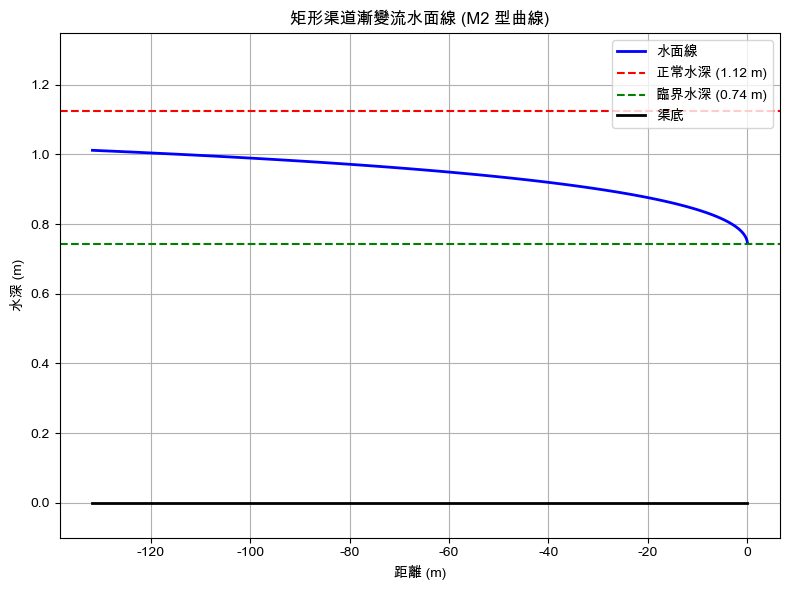

In [6]:
# 繪製水面線圖形
plt.figure(figsize=(8, 6))

# 繪製水面線
plt.plot(x_values, y_values, 'b-', linewidth=2, label='水面線')

# 繪製正常水深線和臨界水深線
plt.axhline(y=y_n, color='r', linestyle='--', label=f'正常水深 ({y_n:.2f} m)')
plt.axhline(y=y_c, color='g', linestyle='--', label=f'臨界水深 ({y_c:.2f} m)')

# 添加渠底線
plt.plot(x_values, np.zeros_like(x_values), 'k-', linewidth=2, label='渠底')

# 設定軸標題和圖例
plt.xlabel('距離 (m)')
plt.ylabel('水深 (m)')
plt.title(f'矩形渠道漸變流水面線 ({profile_type} 型曲線)')
plt.legend()
plt.grid(True)

# 調整y軸範圍，使渠底可見
plt.ylim(-0.1, max(y_n, y_c, y_start) * 1.2)

# 顯示圖形
plt.tight_layout()
plt.show()